# noise model

In [1]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
import random

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [2]:
noise_model = get_noise(0.01,0.00)

In [3]:
from qiskit import QuantumCircuit, execute, Aer

qc0 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state

qc0.measure(qc0.qregs[0],qc0.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute( qc0, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'001': 5, '000': 999, '010': 7, '100': 13}


In [4]:
qc1 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state
qc1.x(qc1.qregs[0]) # flip each 0 to 1

qc1.measure(qc1.qregs[0],qc1.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute( qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'011': 8, '110': 9, '111': 994, '101': 13}


# setting up rep code

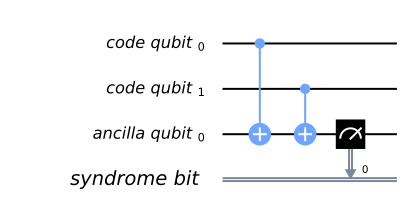

In [5]:
from qiskit import QuantumRegister, ClassicalRegister
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

cq = QuantumRegister(2,'code\ qubit\ ')
lq = QuantumRegister(1,'ancilla\ qubit\ ')
sb = ClassicalRegister(1,'syndrome\ bit\ ')
qc = QuantumCircuit(cq,lq,sb)
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.measure(lq,sb)
qc.draw(output='mpl')

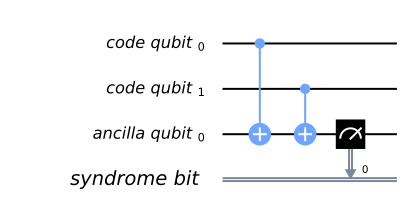

In [6]:
qc_init = QuantumCircuit(cq)

(qc_init+qc).draw(output='mpl')

In [7]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


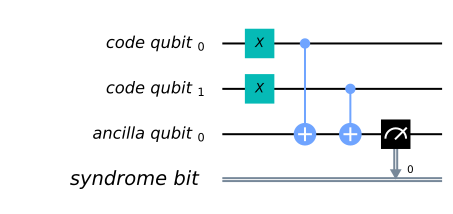

In [8]:
qc_init = QuantumCircuit(cq)
qc_init.x(cq)

(qc_init+qc).draw(output='mpl')


In [9]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


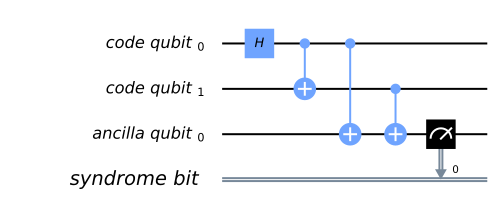

In [10]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0],cq[1])

(qc_init+qc).draw(output='mpl')

In [11]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


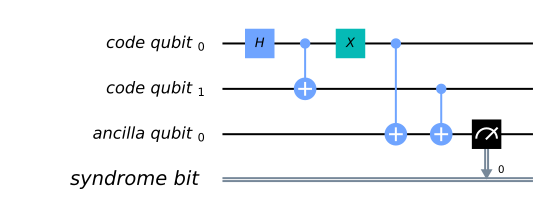

In [12]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0],cq[1])
qc_init.x(cq[0])

(qc_init+qc).draw(output='mpl')

In [13]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'1': 1024}


In [14]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

In [28]:
n = 3
T = 2

code = RepetitionCode(n,T)

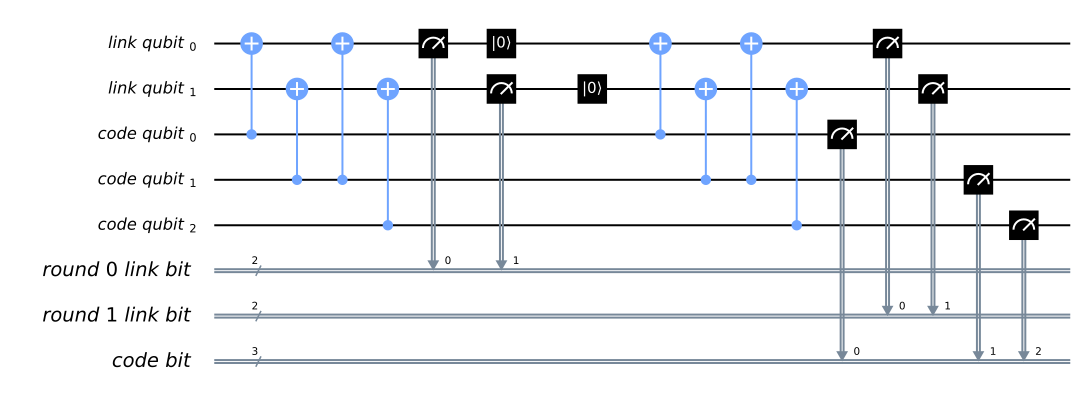

In [29]:
# this bit is just needed to make the labels look nice
for reg in code.circuit['0'].qregs+code.circuit['1'].cregs:
    reg.name = reg.name.replace('_','\ ') + '\ '

code.circuit['0'].draw(output='mpl')

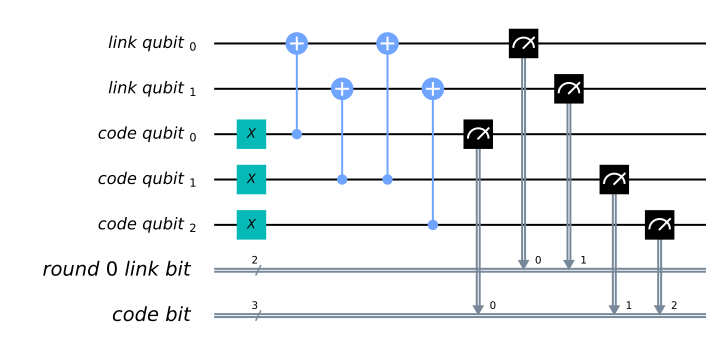

In [24]:
code.circuit['1'].draw(output='mpl')

In [26]:
def get_raw_results(code,noise_model=None):

    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



In [27]:
code = RepetitionCode(n,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00 00 00 00': 1024} 

Logical 1 : {'111 00 00 00 00': 1024} 



In [25]:
code = RepetitionCode(3,1)

noise_model = get_noise(0.05,0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'001 00': 42, '101 01': 1, '011 00': 4, '000 10': 66, '010 01': 21, '001 10': 2, '000 11': 6, '010 11': 1, '001 11': 1, '100 01': 9, '000 01': 65, '000 00': 668, '110 00': 3, '100 10': 4, '010 00': 64, '011 01': 4, '100 00': 51, '101 00': 4, '001 01': 3, '010 10': 5} 

Logical 1 : {'111 01': 58, '001 00': 5, '101 01': 33, '011 00': 51, '000 10': 2, '010 01': 3, '001 10': 4, '111 11': 9, '111 10': 56, '001 11': 2, '100 01': 2, '101 10': 7, '110 00': 53, '010 00': 3, '011 01': 2, '100 00': 2, '011 10': 22, '101 00': 48, '111 00': 621, '101 11': 15, '001 01': 3, '110 01': 17, '110 10': 4, '010 10': 2} 

